# Module 10: Random Forests

## Prerequisites

In [1]:
# Helper packages
import numpy as np
import pandas as pd
from plotnine import *
from scipy.stats import uniform
from scipy.stats import randint

# Modeling packages
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from category_encoders.ordinal import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import partial_dependence
from sklearn.pipeline import Pipeline

In [2]:
# Ames housing data
ames = pd.read_csv("../../00-data/ML/ames.csv")

# create train/test split
train, test = train_test_split(ames, train_size=0.7, random_state=123)

# separate features from labels and only use numeric features
X_train = train.drop("Sale_Price", axis=1)
y_train = train[["Sale_Price"]]

## Out-of-the-box performance

In [3]:
# Ordinal encode our quality-based features 
ord_cols = list(X_train.filter(regex=("Qual$|QC$|Cond$")).columns)
lvs = ["Very_Poor", "Poor", "Fair", "Below_Average", "Average", "Typical", 
       "Above_Average", "Good", "Very_Good", "Excellent", "Very_Excellent"]
val = range(0, len(lvs))
lvl_map = dict(zip(lvs, val))
category_mapping = [{'col': col, 'mapping': lvl_map} for col in ord_cols]
ord_encoder = OrdinalEncoder(cols=ord_cols, mapping=category_mapping)

# one hot encode remaining nominal features
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

# combine into a pre-processing pipeline
preprocessor = ColumnTransformer(
  remainder="passthrough",
  transformers=[
   ("ord_encode", ord_encoder, ord_cols),
   ("one-hot", encoder, selector(dtype_include="object")),
   ]
  )

In [4]:
# create random forest estimator
rf_mod = RandomForestRegressor()

# create modeling pipeline
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("rf_mod", rf_mod),
])

# define loss function
loss = 'neg_root_mean_squared_error'

# create 5 fold CV object
kfold = KFold(n_splits=5, random_state=123, shuffle=True)

# fit model with 5-fold CV
results = cross_val_score(model_pipeline, X_train, y_train.values.ravel(), cv=kfold, scoring=loss)


In [5]:

np.abs(np.mean(results))

27670.44987395571

## Tuning strategies

### Cartesian grid search

In [6]:
%%capture

# create random forest estimator with 1,000 trees
rf_mod = RandomForestRegressor(n_estimators=1000)

# create modeling pipeline
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("rf_mod", rf_mod),
])

# Create grid of hyperparameter values
hyper_grid = {
  'rf_mod__max_features': [.05, .15, .25, .333, .4],
  'rf_mod__min_samples_leaf': [1, 3, 5, 10],
  'rf_mod__bootstrap': [True, False],
  'rf_mod__max_samples': [.5, .63, .8]
  }
  
# Tune a knn model using grid search
grid_search = GridSearchCV(model_pipeline, hyper_grid, cv=kfold, scoring=loss, n_jobs=-1)
results = grid_search.fit(X_train, y_train.values.ravel())


In [7]:

# best model score
np.abs(results.best_score_)

26787.231724754743

In [8]:
# best hyperparameter values
results.best_params_

{'rf_mod__bootstrap': True,
 'rf_mod__max_features': 0.333,
 'rf_mod__max_samples': 0.8,
 'rf_mod__min_samples_leaf': 1}

### Random grid search

In [9]:
%%capture

# Create grid of hyperparameter values
hyper_distributions = {
  'rf_mod__max_features': uniform(.05, .35),
  'rf_mod__min_samples_leaf': randint(1, 9),
  'rf_mod__bootstrap': [True, False],
  'rf_mod__max_samples': uniform(.5, .3)
  }
  
# Tune a knn model using grid search
random_search = RandomizedSearchCV(
  model_pipeline, 
  param_distributions=hyper_distributions, 
  n_iter=20,
  cv=kfold, 
  scoring=loss, 
  n_jobs=-1, 
  random_state=13
  )
random_search_results = random_search.fit(X_train, y_train.values.ravel())


: 

: 

In [ ]:

# best model score
np.abs(random_search_results.best_score_)

27066.2145919465

In [ ]:
# best hyperparameter values
random_search_results.best_params_

{'rf_mod__bootstrap': True,
 'rf_mod__max_features': 0.37868729205270835,
 'rf_mod__max_samples': 0.6615164397309103,
 'rf_mod__min_samples_leaf': 1}

## Feature interpretation

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


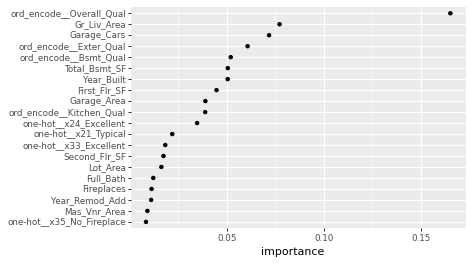

<ggplot: (17592041070939)>

In [ ]:
# create final model object
X_encoded = preprocessor.fit_transform(X_train)
final_model = RandomForestRegressor(
  n_estimators=1000,
  max_features=0.21,
  max_samples=0.65,
  min_samples_leaf=1,
  bootstrap=True
)
final_model_fit = final_model.fit(X_encoded, y_train.values.ravel())

# extract feature importances
vi = pd.DataFrame({'feature': preprocessor.get_feature_names(),
                   'importance': final_model_fit.feature_importances_})

# get top 20 influential features
top_20_features = vi.nlargest(20, 'importance')

# plot feature importance
(ggplot(top_20_features, aes(x='importance', y='reorder(feature, importance)'))
 + geom_point()
 + labs(y=None))

In [ ]:
X_encoded = pd.DataFrame(X_encoded, columns=preprocessor.get_feature_names())
pd_results = partial_dependence(
  final_model_fit, X_encoded, "Gr_Liv_Area", kind='average',
  percentiles=(0, 1)) 
  
pd_output = pd.DataFrame({'Gr_Liv_Area': pd_results['values'][0],
                          'yhat': pd_results['average'][0]})
                          
(ggplot(pd_output, aes('Gr_Liv_Area', 'yhat'))
  + geom_line())

## Exercises

Using the Boston housing data set, where the response feature is the median value of homes within a census tract (`cmedv`):

1. Apply a default random forest model with the same features you used in the bagging module. How does the out-of-the-box random forest model perform compared to the bagging module?
2. Assess the number of trees in your random forest model.
   - How many trees are applied?
   - Was it enough to stabilize the loss function or do you need to add more?
3. Perform a full cartesian grid search across various values of:
   - $m_{try}$
   - tree complexity (i.e. max depth, node size)
   - sampling scheme
4. How long did the above grid search take? Which model gave the best performance?
5. Now run a random grid search across the same hyperparameter grid but restrict the time or number of models to run to 50% of the models ran in the full cartesian. How does the random grid search results compare?
6. Pick your best random forest model. Which 10 features are considered most influential? Are these the same features that have been influential in previous models?
7. Create partial dependence plots for the top two most influential features. Explain the relationship between the feature and the predicted values.
8. Now perform 1-7 to the Attrition dataset, which is classification model rather than a regression model.